# VGG16_transfer_2
- 가중치 imagenet 사용
- 입력 데이터 사이즈 (224,224,3)
- 옵티마이저 adam, 학습률 0.0001
- train 데이터 배치사이즈 100
- 콜백함수  EarlyStopping, ModelCheckpoint

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/안봐도보이조_project

/content/drive/MyDrive/안봐도보이조_project


In [1]:
cd ../

E:\안봐도보이조_project


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

In [3]:
# 데이터셋 준비
train_datagen = ImageDataGenerator(rescale=1./255,         # 픽셀 값을 0~1 범위로 변환(scaling)
                                   rotation_range=40,      # 40도까지 회전
                                   width_shift_range=0.2,  # 20%까지 좌우 이동
                                   height_shift_range=0.2, # 20%까지 상하 이동
                                   shear_range=0.2,        # 20%까지 기울임
                                   zoom_range=0.2,         # 20%까지 확대/축소
                                   horizontal_flip=True)   # 좌우 뒤집기
    
train_generator = train_datagen.flow_from_directory('./train_10', # 데이터가 존재하는 디렉토리
                                                    batch_size=100, # 배치사이즈(변경가능)
                                                    class_mode='categorical', # 다중 분류이므로 categorical
                                                    target_size=(224, 224)) # 모델에 입력해줄 데이터 사이즈(변경가능)

valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory('./valid_10',
                                                    batch_size=20,      
                                                    class_mode='categorical', 
                                                    target_size=(224, 224))

test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory('./test_10',
                                                  batch_size=10,      
                                                  class_mode='categorical', 
                                                  target_size=(224, 224),shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [5]:
# 클래스 확인
print(train_generator.class_indices)

{'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


In [6]:
# 모델 구성 및 확인
tf_model = VGG16(weights='imagenet', # 이미 학습된 가중치 지정
                 include_top=False, # 분류기 제외
                 input_shape=(224, 224, 3)) 
tf_model.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정
model = Sequential()
model.add(tf_model) # VGG16 모델층 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

58900480/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 17,927,370
Trainable params: 3,212,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# 모델 컴파일
model.compile(optimizer = Adam(0.0001), # 최적화함수 adam사용
              loss = 'categorical_crossentropy', # 손실함수 범주형 교차엔트로피 사용
              metrics = ['accuracy']) # 지표는 정확도


In [8]:
# 콜백함수 지정

Model_dir = './송종호/model/' # 저장할 경로
if not os.path.exists(Model_dir): # 해당 경로가 없으면 생성
    os.mkdir(Model_dir)
    
modelpath = './송종호/model/VGG16_4_{epoch:d}_{val_loss:.4f}.h5' # 저장할 경로 및 파일명 지정

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

In [9]:
# 모델 학습
history = model.fit(train_generator,
                    steps_per_epoch=100,  
                    epochs=100, 
                    validation_data=valid_generator, 
                    validation_steps=30, callbacks=[checkpointer,earlystopping]) 

Epoch 1/100
100/100 [==============================] - 5505s 55s/step - loss: 1.2638 - accuracy: 0.6429 - val_loss: 0.5746 - val_accuracy: 0.8967
Epoch 2/100
100/100 [==============================] - 489s 5s/step - loss: 0.5100 - accuracy: 0.8923 - val_loss: 0.3179 - val_accuracy: 0.9517
Epoch 3/100
100/100 [==============================] - 169s 2s/step - loss: 0.3434 - accuracy: 0.9288 - val_loss: 0.2311 - val_accuracy: 0.9650
Epoch 4/100
100/100 [==============================] - 140s 1s/step - loss: 0.2591 - accuracy: 0.9478 - val_loss: 0.1940 - val_accuracy: 0.9583
Epoch 5/100
100/100 [==============================] - 126s 1s/step - loss: 0.2088 - accuracy: 0.9584 - val_loss: 0.1449 - val_accuracy: 0.9783
Epoch 6/100
100/100 [==============================] - 125s 1s/step - loss: 0.1750 - accuracy: 0.9640 - val_loss: 0.1192 - val_accuracy: 0.9900
Epoch 7/100
100/100 [==============================] - 121s 1s/step - loss: 0.1520 - accuracy: 0.9696 - val_loss: 0.1046 - val_accurac

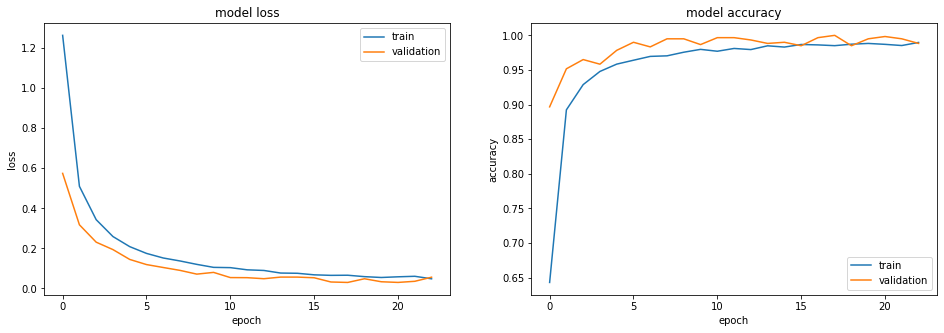

In [10]:
# 모델 학습 과정 시각화
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [11]:
# 모델 저장
model.save('./송종호/VGG16_4.h5')

In [4]:
model = load_model('./송종호/model/VGG16_4_18_0.0300.h5')

In [14]:
# 모델 평가
model.evaluate(test_generator)

50/50 [==============================] - 279s 6s/step - loss: 0.0243 - accuracy: 0.9980


[0.02425241842865944, 0.9980000257492065]

In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [6]:
import matplotlib.pyplot as plt 
plt.rc('font', family='NanumBarunGothic')

Text(0.5, 1.0, '0.98확률로 레쓰비입니다')

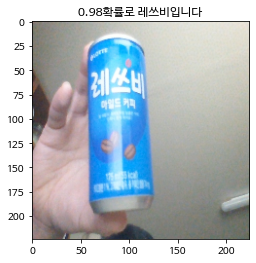

In [7]:
# 직접 찍은 음료 이미지로 예측 결과 확인

class_dict = {0:'갈아만든배', 1:'레쓰비', 2:'마운틴듀', 3:'밀키스', 4:'스프라이트', 5:'칠성사이다', 6:'코카콜라', 7:'트로피카나망고', 8:'펩시콜라', 9:'환타오렌지'}

test_img = cv2.imread('./123.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img_input = test_img.reshape((1,)+test_img.shape)
pred = model.predict(test_img_input)
pred_class = class_dict[np.argmax(pred, axis=1)[0]]
plt.imshow(test_img)
# print(f'{pred.max():.2f}확률로 {pred_class}입니다')
plt.title(f'{pred.max():.2f}확률로 '+pred_class+'입니다')

In [8]:
Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1) 

# class_names = ['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'] 
result_dict = dict(map(reversed, test_generator.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))


-- Confusion Matrix --
[[50  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  1  0]
 [ 0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
-- Classification Report --
              precision    recall  f1-score   support

       갈아만든배       1.00      1.00      1.00        50
         레쓰비       1.00      0.98      0.99        50
        마운틴듀       1.00      1.00      1.00        50
         밀키스       1.00      1.00      1.00        50
       스프라이트       1.00      1.00      1.00        50
       칠성사이다       1.00      1.00      1.00        50
        코카콜라       1.00      1.00      1.00        50
     트로피카나망고       1.00      1.00      1.00        50
        펩시콜라       0.98      1.00      0.99        50
       환타오렌지       1.00      1.00      1.00        50

    accuracy          

<AxesSubplot:>

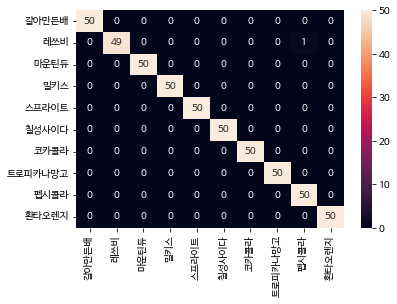

In [9]:
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'] ,
            yticklabels=['갈아만든배', '레쓰비', '마운틴듀', '밀키스', '스프라이트', '칠성사이다', '코카콜라', '트로피카나망고', '펩시콜라', '환타오렌지'] )